A simple example of how to initialize a Graph object with Langgraph

hello there I am happy


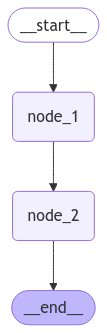

In [1]:
from langgraph.graph import Graph, START, END


def function_1(input_1):
    return input_1 + " I am "

def function_2(input_2):
    return input_2 + "happy"



# Define a graph
workflow = Graph()

# define nodes
workflow.add_node("node_1", function_1)
workflow.add_node("node_2", function_2)

# define edges
workflow.add_edge(START, 'node_1')
workflow.add_edge('node_1', 'node_2')
workflow.add_edge('node_2', END)

graph = workflow.compile()


print(graph.invoke("hello there"))

from IPython.display import Image

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Now we will proceed with an AI Agent that can store calenders in google calenders

In [ ]:
%pip install -qU langchain langchain-google-genai
%pip install python-dotenv


Note: you may need to restart the kernel to use updated packages.


get gemini api


In [2]:
import os
from dotenv import load_dotenv

load_dotenv()
gemini_api_key = os.getenv("GEMINI_API_KEY")

using gemini api key to get access to llm 

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

model: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-exp",
    api_key=gemini_api_key    
)

Trying the model 

In [4]:
response = model.invoke("Hello there")
response

AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-6a3db7b4-1e29-4208-ab9c-f7700cd91ff6-0', usage_metadata={'input_tokens': 2, 'output_tokens': 10, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

Lets Create node of the graph and try using the llm , first we import some stuff like special type of dict, annotated list , anymessages to store every type of message and add_message to directly add messages to the annotated list

In [231]:
from typing import TypedDict, Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langchain_core.tools import tool

class agentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]  



Then we create a derived class of typedDict and initialize a annotated list init

Connecting to the google calender to add and get events from there

In [207]:
%pip install google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client


In [208]:
import os
import datetime
from google.oauth2 import service_account
from googleapiclient.discovery import build

# Load service account credentials
SERVICE_ACCOUNT_FILE = "D:/Ai agents/exeFiles/service-account.json"  # Path to your JSON key
SCOPES = ["https://www.googleapis.com/auth/calendar"]

credentials = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE, scopes=SCOPES
)

# Connect to Google Calendar API
service = build("calendar", "v3", credentials=credentials)
print("✅ Connected to Google Calendar API!")



✅ Connected to Google Calendar API!


Lets extract the date from user query 

In [209]:

@tool
def extract_date(userInput: str):
    """ function to extract date from the user input
    Args:
        userInput (str): user input
    Returns:
        str: date in the format YYYY-MM-DD
    """
    response = model.invoke(f"Your job is to extract date from the {userInput} and return it as a string in the YYYY-MM-DD format")
    return response.content


Lets fetch events from Google Calendar

In [210]:

@tool
def upcoming_events(date:str):

    """
    Function to get upcoming events from Google Calendar
    Args:
        date (str): Format: 'YYYY-MM-DD' (UTC) or 'YYYY-MM-DDTHH:MM:SS±HH:MM' (Local Time)
        Example: '2025-02-21' (UTC) or '2025-02-21' (Pakistan Time)
    Returns:
        list: list of upcoming events if found
        string: message if no events found
    """

    # Convert date to RFC 3339 format (start and end of the day)
    time_min = f"{date}T00:00:00Z"  # Start of the day in UTC
    time_max = f"{date}T23:59:59Z"  # End of the day in UTC

    events_result = service.events().list(
        calendarId="yk5645123@gmail.com",
        timeMin=time_min,
        timeMax=time_max,
        singleEvents=True,
        orderBy="startTime"
    ).execute()

    events = events_result.get("items", [])
    if not events:
        return "No events found for this date."

    return events
        



lets create a helper function that extracts data from user query

In [211]:
@tool
def extract_date_startTime_endTime_summary_location_description(userInput: str):
    """ function to extract date, start time, end time, summary, location, and description from the user input
    Args:
    userInput (str): user input
    Returns:
    dict: event data extracted from user query and name the dict, eventData
    """
    response = model.invoke(f"""Your job is extract date, start time, end time, summary, location, and description from the {userInput} in formatdate (str): The date of the event in 'YYYY-MM-DD' format.
        startTime (str): The start time of the event in 'HH:MM' 24-hour format.
        endTime (str): The end time of the event in 'HH:MM' 24-hour format.
        summary (str): The title or summary of the event.
        location (str): The location of the event.
        description (str): Additional details about the event. and return them as a dict with keys as the output specified and the data extracted from user query and name the dict, eventData , make sure that if time is not specified just send 00:00 and nothing else""")
    return response.content

Adding events to the calendar 

In [212]:
@tool
def add_event(userData:dict):
    """
    Adds an event to the user's Google Calendar.

    Args:
        userData (dict): Contains the following
            - date (str): The date of the event in 'YYYY-MM-DD' format.
            - startTime (str): The start time of the event in 'HH:MM' 24-hour format.
            - endTime (str): The end time of the event in 'HH:MM' 24-hour format.
            - summary (str): The title or summary of the event.
            - location (str): The location of the event.
            - description (str): Additional details about the event.


    Returns:
        str: A success message with the event link if created successfully.
        str: An error message if event creation fails.

    Example Usage:
        add_event("2025-02-21", "17:00", "18:00", "Meeting", "Virtual", "Discussion on project updates.")

    Expected Format:
        - Date: '2025-02-21'
        - Start Time: '17:00' (5:00 PM)
        - End Time: '18:00' (6:00 PM)
    
    Notes:
        - The function assumes the time is in UTC.
        - The event is set to "public" visibility.
    """
    try:
        # Convert date and time to the correct format
        date = userData["date"]
        startTime = userData["startTime"]
        endTime = userData["endTime"]
        summary = userData["summary"]
        location = userData["location"]
        description = userData["description"]
        start_datetime = f"{date}T{startTime}:00Z"
        end_datetime = f"{date}T{endTime}:00Z"

        event = {
            "summary": summary,
            "location": location,
            "description": description,
            "start": {"dateTime": start_datetime, "timeZone": "UTC"},
            "end": {"dateTime": end_datetime, "timeZone": "UTC"},
            "visibility": "public",
        }

        # Replace with your actual Calendar ID
        CALENDAR_ID = "yk5645123@gmail.com"

        event_result = service.events().insert(calendarId=CALENDAR_ID, body=event).execute()
        return f" Event created: {event_result.get('htmlLink')}"

    except Exception as e:
        return f" An error occurred: {e}"


   

Lets create nodes and agent now 

Binding tools with the llm

In [213]:
tools = [extract_date,upcoming_events,extract_date_startTime_endTime_summary_location_description,add_event]
model_with_tools = model.bind_tools(tools)

Lets check the llm and its responses

In [214]:
response = model_with_tools.invoke("add event to my calender on feb 21 2025 which will start at 10 am and end at 12 pm , will be held at virtual and its about the my first job as a software engineer, also make sure that i dont have events on that date and time and if there are please tell me details")

response

AIMessage(content='', additional_kwargs={'function_call': {'name': 'upcoming_events', 'arguments': '{"date": "2025-02-21"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-a2cdb5a6-4845-4218-a0bf-830335623008-0', tool_calls=[{'name': 'upcoming_events', 'args': {'date': '2025-02-21'}, 'id': '2ff5843f-8634-48ee-a524-7d48b9a0365d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 598, 'output_tokens': 14, 'total_tokens': 612, 'input_token_details': {'cache_read': 0}})

Lets create a work flow now using langchain and langgraph

In [233]:
def function_1(state:agentState):
    messages = state['messages']
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

Tools node for all the tools 1

In [234]:
from langgraph.prebuilt import ToolNode

function_2 = ToolNode(tools)

In [235]:
from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import tools_condition
from langgraph.graph.state import CompiledStateGraph



workflow = StateGraph(agentState)  # Ensure AgentState is defined properly

# Define your nodes properly
workflow.add_node("llm", function_1)  
workflow.add_node("tools", function_2)  

# Define the flow of execution
workflow.add_edge(START, "llm")
workflow.add_conditional_edges("llm", tools_condition)
workflow.add_edge("tools", "llm")

# **Ensure there is an END condition**
workflow.add_edge("llm", END)  # If LLM should sometimes terminate

# Compile the graph
graph: CompiledStateGraph = workflow.compile()


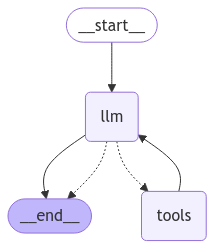

In [236]:
from IPython.display import Image

# View
display(Image(graph.get_graph().draw_mermaid_png()))

lets test it now

In [240]:
from langchain_core.messages import HumanMessage


# to_markdown(graph.invoke(inputs))
output = graph.invoke({"messages": [HumanMessage("add event to my calender on feb 21 2025 which will start at 10 am and end at 12 pm , will be held at virtual and its about the my first job as a software engineer, also make sure that i dont have events on that date and time and if there are please tell me details")]})

for o in output['messages']:
    o.pretty_print()

================================ Human Message =================================

add event to my calender on feb 21 2025 which will start at 10 am and end at 12 pm , will be held at virtual and its about the my first job as a software engineer, also make sure that i dont have events on that date and time and if there are please tell me details
================================== Ai Message ==================================
Tool Calls:
  upcoming_events (c60431d4-6e89-4741-b989-6baa5db36103)
 Call ID: c60431d4-6e89-4741-b989-6baa5db36103
  Args:
    date: 2025-02-21
================================= Tool Message =================================
Name: upcoming_events

[{"kind": "calendar#event", "etag": "\"3480133152840000\"", "id": "c6m92f8klrg10tapvjng1ilijs", "status": "confirmed", "htmlLink": "https://www.google.com/calendar/event?eid=YzZtOTJmOGtscmcxMHRhcHZqbmcxaWxpanMgeWs1NjQ1MTIzQG0", "created": "2025-02-20T15:49:36.000Z", "updated": "2025-02-20T15:49:36.420Z", "summary": "AI Ag